# Tutorial 21: Sparse Modes with region detection <br>
<br>
Tutorial 21: Sparsify DMD modes using dmd_modes_tuner module<br>
Within this tutorial we show how to sparsify DMD modes and further detect regions of interests.
Each value of the modes are enforced to lie in the pixel space [0, 255].

In [6]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import morphology
from skimage.color import label2rgb
from skimage.measure import label

from pydmd import DMD
from pydmd.dmd_modes_tuner import BOUND, sparsify_modes

[snapshots.py:36 -             __init__() ] Snapshots: (25920, 11), snapshot shape: (25920,)
[snapshots.py:36 -             __init__() ] Snapshots: (25920, 11), snapshot shape: (25920,)
[snapshots.py:36 -             __init__() ] Snapshots: (25920, 11), snapshot shape: (25920,)


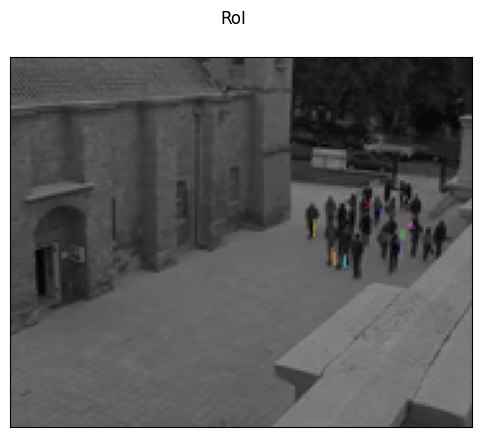

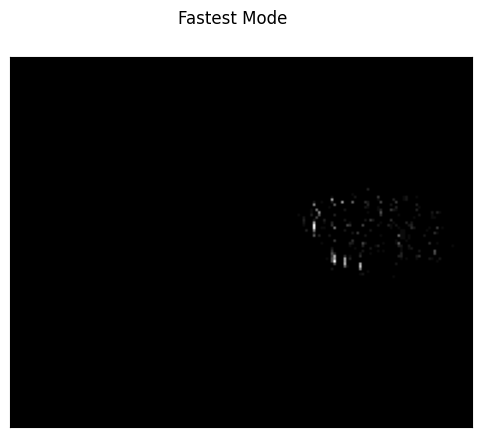

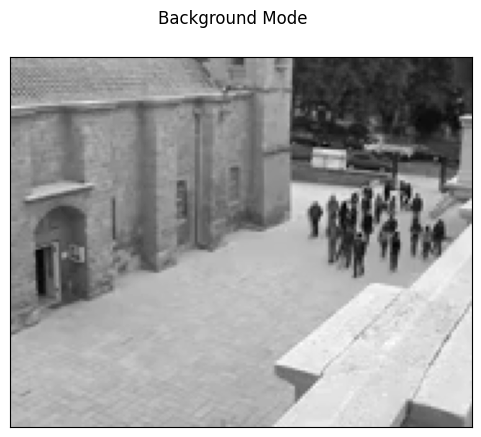

In [7]:
if __name__ == "__main__":

    DIR = os.path.abspath("")
    DIR = os.path.join("video")
    READ_FRAMES = 12
    AREA_SIZE_MIN = 5
    AREA_SIZE_MAX = 1000.0
    PIXELTHRESH = 0
    cap = cv2.VideoCapture(os.path.join(DIR, "flock.mp4"))
    if not cap.isOpened():
        raise FileNotFoundError(
            os.path.join(DIR, "flock.mp4") + " does not exist!"
        )
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # float `width`
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # float `height`
    images = np.zeros((int(height), int(width), READ_FRAMES), dtype=np.uint8)
    frames_read = 0
    for i in range(READ_FRAMES):
        if cap.isOpened():
            ret, frame = cap.read()
            if ret:
                images[..., i] = frame[..., 0]
                frames_read += 1
    images = images[..., :frames_read]
    images = images[..., ::-1]
    obs = images.flatten().reshape((-1, frames_read))
    dmd = DMD()
    dmd.fit(obs[:, :-1], obs[:, 1:])
    omegas = np.log(dmd.eigs) * fps
    sorted_idx = np.argsort(np.abs(omegas.imag))
    time = np.arange(obs.shape[-1]) * np.reciprocal(fps)

    # constrain real part of modes to lie within [0, 255]
    bounds_real = BOUND(0.0, 255.0)
    bounds_imag = BOUND(0.0, 0.0)

    sparse_modes, amps, idx_ok = sparsify_modes(
        omegas,
        time,
        obs,
        beta=1e-4,
        bounds_real=bounds_real,
        bounds_imag=bounds_imag,
        max_iter=5,
    )

    omegas = omegas[idx_ok]
    sparse_modes = sparse_modes[:, sorted_idx]
    dense_modes = dmd.modes[:, sorted_idx]
    amps = amps[sorted_idx]
    omegas = omegas[sorted_idx]

    img_grey_fast = np.reshape(
        ((sparse_modes[:, -1] * amps[-1]).real).astype(np.uint8),
        (int(height), int(width)),
    )
    img_grey_bg = np.reshape(
        ((sparse_modes[:, 0] * amps[0]).real).astype(np.uint8),
        (int(height), int(width)),
    )
    msk = img_grey_fast > PIXELTHRESH
    msk = morphology.remove_small_objects(msk, AREA_SIZE_MIN)
    labels = label(msk, connectivity=1)
    img_overlay = label2rgb(labels, images[..., 0])

    fig1, ax1 = plt.subplots(1, 1)
    fig2, ax2 = plt.subplots(1, 1)
    fig3, ax3 = plt.subplots(1, 1)

    ax1.imshow(img_overlay)
    ax1.get_xaxis().set_ticks([])
    ax1.get_yaxis().set_ticks([])
    ax2.imshow(img_grey_fast, cmap="gray")
    ax2.get_xaxis().set_ticks([])
    ax2.get_yaxis().set_ticks([])
    ax3.imshow(img_grey_bg, cmap="gray")
    ax3.get_xaxis().set_ticks([])
    ax3.get_yaxis().set_ticks([])

    fig1.suptitle("RoI")
    fig2.suptitle("Fastest Mode")
    fig3.suptitle("Background Mode")

    plt.show()